In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score
from tensorflow.keras.models import clone_model
from tqdm import tqdm
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.model_selection import train_test_split
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-behavior-dataset/Customer_Behavior_Data.csv
/kaggle/input/ps-dataset/order_data_last_six_month.xlsx - Worksheet.csv
/kaggle/input/ps-dataset/associated_order_item_data_last_six_month.xlsx - Worksheet.csv


In [42]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)


TensorFlow version: 2.18.0
Keras version: 3.5.0


In [ ]:
def piechart(series):
    """
    Automatically plots a pie chart from a Pandas Series.
    - Uses the series name as the chart title.
    - Displays value counts as percentages.
    """
    if not isinstance(series, pd.Series):
        raise TypeError("Input must be a pandas Series")

    counts = series.value_counts(dropna=False)
    labels = counts.index.astype(str)
    
    # Auto-title using series name or fallback
    title = series.name if series.name else "Pie Chart"

    # Plot
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, counterclock=False)
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
    plt.show()

In [ ]:
beh_data=pd.read_csv("/kaggle/input/customer-behavior-dataset/Customer_Behavior_Data.csv")

In [ ]:
zero_people=beh_data[beh_data['Total Orders']<=4]['customer_id']

In [ ]:
cluster_1_people=beh_data[((beh_data['Total Orders']<=25) & (beh_data['Total Orders']>4) & (beh_data['Average Order Gap Days']>=14))]['customer_id']

In [ ]:
cluster_2_people = beh_data['customer_id'][~beh_data['customer_id'].isin(cluster_1_people) & ~beh_data['customer_id'].isin(zero_people)]

In [ ]:
dataset=pd.read_csv("/kaggle/input/ps-dataset/order_data_last_six_month.xlsx - Worksheet.csv")

In [ ]:
train_data=dataset[dataset['customer_id'].isin(cluster_2_people)]

In [ ]:
train_data.head()

In [ ]:
train_data.drop(['order_number','customer_name','poc_name','poc_id','amount','profit','order_status','warehouse_id'],axis=1,inplace=True)

In [ ]:
import pandas as pd

# assume train_data is your original DataFrame
df = train_data.copy()
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=True)

# group & aggregate:
daily_df = df.groupby(['customer_id','order_date']).agg(
    daily_order_count = ('order_id',       'count'),
    discount          = ('discount',       'sum'),
    net_order_amount  = ('net_order_amount','sum'),
    warehouse_name    = ('warehouse_name', 'first')  # or use mode if you prefer
).reset_index()

# now daily_df has exactly one row per customer per date
daily_df

In [ ]:
daily_df_dummy=pd.get_dummies(daily_df,columns=['warehouse_name'],dtype='int')

In [ ]:
SEQ_LEN = 30
PRED_HORIZON = 14

In [33]:
df = daily_df_dummy.copy()
df['order_date'] = pd.to_datetime(df['order_date'])

# Add 'day_of_week' column
df['day_of_week'] = df['order_date'].dt.dayofweek  # Monday=0, Sunday=6

# One-hot encode 'day_of_week'
df = pd.get_dummies(df, columns=['day_of_week'], prefix='dow',dtype='int')

# Identify feature columns (exclude ID/date)
feature_cols = [c for c in df.columns 
                if c not in ('customer_id', 'order_date')]

# Containers for sequence data
X, y = [], []

for cust_id, group in tqdm(df.groupby('customer_id'), total=df['customer_id'].nunique()):
    group = group.set_index('order_date').sort_index()
    full_idx = pd.date_range(group.index.min(), group.index.max(), freq='D')
    group = group.reindex(full_idx).fillna(0)
    
    # keep customer_id and date
    group['customer_id'] = cust_id
    group['date'] = group.index
    
    data = group[feature_cols].values
    targets = (group['daily_order_count'] > 0).astype(int).values

    n = len(group)
    for start in range(n - SEQ_LEN - PRED_HORIZON + 1):
        end = start + SEQ_LEN
        fend = end + PRED_HORIZON
        
        X.append(data[start:end, :])     # shape: (30, num_features)
        y.append(targets[end:fend])      # shape: (14,)

X = np.stack(X)
y = np.stack(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

100%|██████████| 1932/1932 [00:04<00:00, 438.79it/s]


X shape: (180411, 30, 16)
y shape: (180411, 14)


In [44]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        # Clip the predictions to prevent log(0) error
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        
        # Calculate cross-entropy
        ce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        
        # Calculate p_t
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        
        # Modulating factor
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        
        # Alpha factor
        alpha_weight = y_true * alpha + (1 - y_true) * (1 - alpha)
        
        # Focal Loss
        focal_loss = alpha_weight * modulating_factor * ce
        return tf.reduce_mean(focal_loss)
    
    return focal_loss

In [45]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.4,random_state=42)
X_cv,X_test,Y_cv,Y_test=train_test_split(X_test,Y_test,test_size=0.5,random_state=42)

In [55]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced',
                                classes=[0,1],
                                y=y.flatten())
class_weight = {0: weights[0], 1: weights[1]}

In [56]:
from tensorflow.keras.optimizers import Adam

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming you have already defined:
# SEQ_LEN = 30
# PRED_HORIZON = 14
# feature_cols = [...]  # list of your input column names

NUM_FEATURES = len(feature_cols)

model = Sequential([
    # 1st LSTM layer, returns sequences so we can stack another LSTM
    LSTM(128, input_shape=(SEQ_LEN, NUM_FEATURES), return_sequences=True),
    Dropout(0.2),

    # 2nd LSTM layer
    LSTM(64, return_sequences=False),
    Dropout(0.2),

    # Dense “bottleneck” to learn combined features
    Dense(32, activation='relu'),
    Dropout(0.1),

    # Final output: 14 sigmoid neurons, one per future day
    Dense(PRED_HORIZON, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=binary_focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 30, 128)             │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 14)                  │             462 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,190 (492.93 KB)

 Trainable params: 126,190 (492.93 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
checkpoint = ModelCheckpoint(
    filepath='best_model.weights.h5',      # Path to save the model weights
    monitor='val_loss',                    # Metric to monitor
    save_best_only=True,                   # Save only the best weights
    save_weights_only=True,                # Save only weights (not full model)
    mode='min',                            # 'min' for loss, 'max' for accuracy
    verbose=1
)

In [59]:
history = model.fit(
    X_train, Y_train,
    class_weight=class_weight,
    epochs=100,
    batch_size=64,
    validation_data=(X_cv, Y_cv),
    callbacks=[checkpoint]  # You can add ModelCheckpoint or EarlyStopping if needed
)

Epoch 1/100
1689/1692 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0726 - loss: 0.0619
Epoch 1: val_loss improved from inf to 0.04246, saving model to best_model.weights.h5
1692/1692 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.0726 - loss: 0.0618 - val_accuracy: 0.0772 - val_loss: 0.0425
Epoch 2/100
 453/1692 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.0789 - loss: 0.0492

KeyboardInterrupt: 

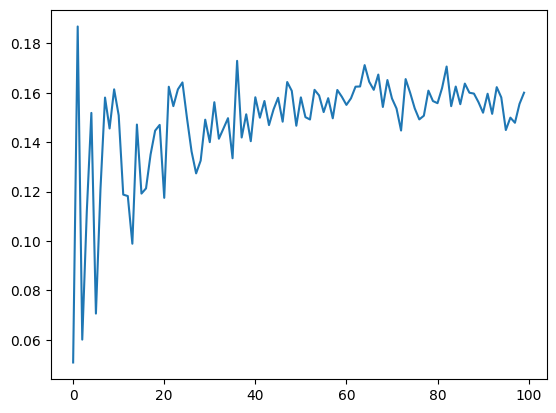

In [50]:
plt.plot(history.history['val_accuracy'])

In [51]:
pred_train=model.predict(X_train)
pred_train_bin= (pred_train > 0.5).astype(int)
print("Training Data:")

print("Accuracy is ",accuracy_score(Y_train,pred_train_bin))
print("Precision is ",precision_score(Y_train,pred_train_bin,average='macro'))
print("Recall is ",recall_score(Y_train,pred_train_bin,average='macro'))
print("F1 Score is ",f1_score(Y_train,pred_train_bin,average='macro'))

pred_val=model.predict(X_cv)
pred_val_bin= (pred_val > 0.5).astype(int)
print("Validation Data:")

print("Accuracy is ",accuracy_score(Y_cv,pred_val_bin))
print("Precision is ",precision_score(Y_cv,pred_val_bin,average='macro'))
print("Recall is ",recall_score(Y_cv,pred_val_bin,average='macro'))
print("F1 Score is ",f1_score(Y_cv,pred_val_bin,average='macro'))


3383/3383 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Training Data:
Accuracy is  0.14425475306246882
Precision is  0.6656199798953957
Recall is  0.16696108646053495
F1 Score is  0.2669131327784589
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Validation Data:
Accuracy is  0.14059641926722466
Precision is  0.6596208678505251
Recall is  0.16440858262195607
F1 Score is  0.2631389867723102


In [52]:

model_best = clone_model(model)

# Important: you need to compile it again
model_best.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Load the best saved weights
model_best.load_weights('best_model.weights.h5')
pred_val=model_best.predict(X_cv)
pred_val_bin= (pred_val > 0.5).astype(int)
pred_train=model_best.predict(X_train)
pred_train_bin= (pred_train> 0.5).astype(int)
print("Training Data:")

print("Accuracy is ",accuracy_score(Y_train,pred_train_bin))
print("Precision is ",precision_score(Y_train,pred_train_bin,average='macro'))
print("Recall is ",recall_score(Y_train,pred_train_bin,average='macro'))
print("F1 Score is ",f1_score(Y_train,pred_train_bin,average='macro'))

print("Validation Data:")

print("Accuracy is ",accuracy_score(Y_cv,pred_val_bin))
print("Precision is ",precision_score(Y_cv,pred_val_bin,average='macro'))
print("Recall is ",recall_score(Y_cv,pred_val_bin,average='macro'))
print("F1 Score is ",f1_score(Y_cv,pred_val_bin,average='macro'))


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1128/1128 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
3383/3383 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Training Data:
Accuracy is  0.14425475306246882
Precision is  0.6656199798953957
Recall is  0.16696108646053495
F1 Score is  0.2669131327784589
Validation Data:
Accuracy is  0.14059641926722466
Precision is  0.6596208678505251
Recall is  0.16440858262195607
F1 Score is  0.2631389867723102
